In [1]:
#import networkx as nx
import osmnx as ox
import math
import numpy as np
import json

import matplotlib.pyplot as plt

%matplotlib inline
ox.__version__

'1.3.0'

# Cargar datos exatraídos

In [2]:
G = ox.load_graphml('grafo_el_poblado.graphml')

#G = ox.load_graphml('grafo_de_interes.graphml')

Calcular los grados de elevación entre los nodos y guardar las distancias

In [3]:
angles = dict()
distances = dict()
for u, v, k, data in G.edges(keys=True, data=True):
    start_elev = G.nodes[u]['elevation']
    end_elev = G.nodes[v]['elevation']
    length = data['length']
    distances[(u,v)] = length
    elevation = data['elevation']
    angle = math.atan2(end_elev - start_elev, length)
    angle = math.degrees(angle)
    angles[(u, v)] = angle
    #print(f"La arista ({u}, {v}) tiene un ángulo de elevación de {math.degrees(angle)} grados y una elevación de {elevation} metros")
    #print(f"La arista ({u}, {v}) tiene un ángulo de elevación de {angle} grados y una elevación de {elevation} metros")

Lugares de interés

In [4]:
# El tesoso
# ISA
# Amsterdam
# Mall Zona 2
# Mall la visitación
# Clínica El Rosario
# La Vaquita (los balsos)
# Euro (la inferior)
# Mall del este
# Complex los balsos

lugares_poligono = {
    'Complex Los Balsos': [6.186898127000028, -75.56143294740268],
    'Mall Del Este': [6.198756717661721, -75.556393638567],
    'Amsterdam Plaza' : [6.202176172201083, -75.55510765722],
    'Euro Supermercados La Inferior': [6.199854351194308, -75.56472210973091],
    'Mall Zona 2': [6.1985640740178996, -75.56511452001308],
    'Mall La Visitación': [6.196673041613839, -75.56516852042641],
    'Complex Los Balsos 2': [6.186898127000028, -75.56143294740268],
}

# Exploración de los datos
Grafo con los lugares de interés en color azul

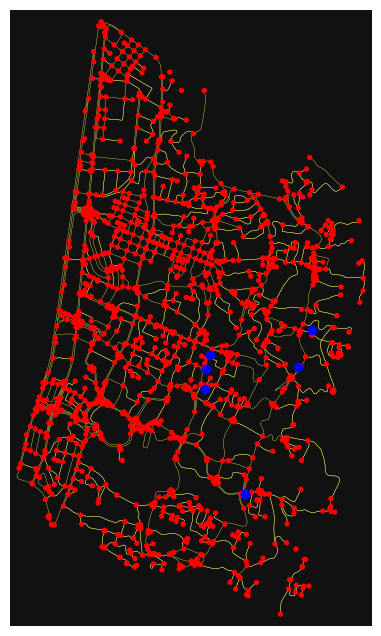

In [5]:
points = [tuple(coord) for coord in lugares_poligono.values()]

places = ['El poblado, Medellín, Colombia']
# use retain_all to keep all disconnected subgraphs (e.g. if your places aren't contiguous)
GP = ox.graph_from_place(places, network_type="drive", retain_all=True)
fig, ax = ox.plot_graph(GP, edge_color="#FFFF5C", edge_linewidth=0.25, node_color='red', show=False)


# Plot the additional points with a different color
x, y = zip(*points)
ax.scatter(y, x, c='blue', marker='o')  # Change 'blue' to the desired color

# Show the plot
plt.show()

Histograma con los ángulos de elevación

In [6]:
data = angles.values()

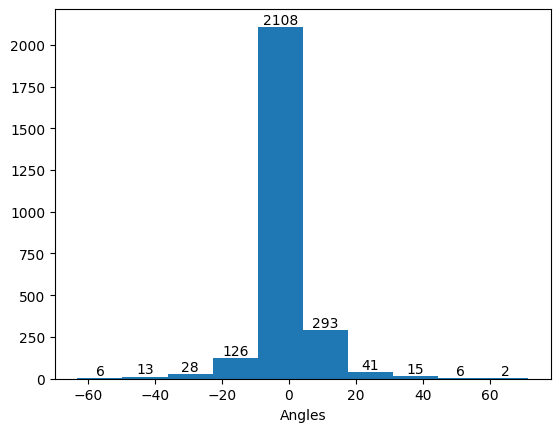

In [7]:
counts, edges, bars = plt.hist(data)
plt.bar_label(bars)
plt.xlabel('Angles')
#plt.ylabel('Cont')
plt.show()

Máximo y mínimo ángulo de inclinación

In [8]:
max(data), min(data)

(71.57929445070624, -63.28045915419252)

# Preparación del problema
Dentro del grafo, buscar el nodo más cercano a la ubicación real de nuestros lugares

In [9]:
threshold = 50  # in meters, maximum distance allowed
lugares_dentro_grafo = {}

for key in lugares_poligono.keys():
    # Neartes node to the coord
    coord = lugares_poligono[key]
    node, dist = ox.nearest_nodes(G, X=coord[1], Y=coord[0], return_dist=True)

    # Verify if the node is near of the point
    if dist <= threshold:
        #print(f"El lugar '{place}' está en el grafo")
        lugares_dentro_grafo[key] = [node, dist]
    else:
        print(f"El lugar '{key}' está a {dist:.2f} metros del grafo, que está a más de {threshold:.2f} metros de distancia")


Nuestro lugar de interés junto con las coordenadas del nodo más cercano dentro del grafo

In [10]:
lugares_dentro_grafo

{'Complex Los Balsos': [3791874410, 11.355795305506582],
 'Mall Del Este': [416767512, 30.707238469926278],
 'Amsterdam Plaza': [1838314584, 35.62863147284505],
 'Euro Supermercados La Inferior': [6349911457, 24.08911669431766],
 'Mall Zona 2': [329582048, 28.886984474203626],
 'Mall La Visitación': [1839319073, 33.39625496118578],
 'Complex Los Balsos 2': [3791874410, 11.355795305506582]}

# Buscar las rutas más cercanas entre dos nodos

In [11]:
balsos = lugares_dentro_grafo['Complex Los Balsos']
euro = lugares_dentro_grafo['Euro Supermercados La Inferior']
ox.shortest_path(G, balsos[0], euro[0])

[3791874410,
 5476066477,
 5476066463,
 2295122024,
 4956865985,
 416765396,
 1838305729,
 4005420723,
 4005420729,
 417235415,
 8475755972,
 2379659021,
 1839319080,
 549456073,
 1839319054,
 1839319060,
 3700963203,
 6349911457]

Buscar las 5 rutas más cercanas dentro del grafo

In [12]:
paths = ox.k_shortest_paths(G, balsos[0], euro[0], 5)
paths

<generator object k_shortest_paths at 0x7f9d12db0480>

In [13]:
for path in paths:
    print(path)

[3791874410, 5476066477, 5476066463, 2295122024, 4956865985, 416765396, 1838305729, 4005420723, 4005420729, 417235415, 8475755972, 2379659021, 1839319080, 549456073, 1839319054, 1839319060, 3700963203, 6349911457]
[3791874410, 5476066477, 5476066463, 2295122024, 4956865985, 416765396, 1838305729, 4005420723, 4005420729, 417235415, 8475755972, 2379659021, 1839319080, 549456073, 1839319054, 1839319060, 3700963203, 1839319067, 549456381, 4005445985, 4353060139, 5914980487, 4005445987, 5914979672, 5914979674, 7139848869, 6349911457]
[3791874410, 5476066477, 5476066463, 2295122024, 4956865985, 416765396, 1838305729, 4005420723, 4005420729, 417235415, 8475755972, 2379659021, 1839319080, 549456073, 1839319054, 1839319060, 3700963203, 1839319067, 549456381, 4005445985, 4353060139, 417233923, 5914980487, 4005445987, 5914979672, 5914979674, 7139848869, 6349911457]
[3791874410, 2620471859, 5476066357, 5476066356, 3774395367, 3774395377, 5476066345, 3774394585, 5476066463, 2295122024, 4956865985, 

# Definición del modelo de consumo de energía

## Definición de funciones de eficiencia (efficiency functions)
**IMPORTANTE: ellos usan análisis de regresión para estimar cada función. Eso, con datos simulados por el Goblal Simulation Platform (GSP) de Volvo Group**

Los valores o funciones que tenemos que definir están abajo, en los últimos parámetros.

In [14]:
def eta_aceleracion(mechanical_energy, information):
    if mechanical_energy >= 0:
        return information['eta_aceleration_positive']
    else:
        return information['eta_aceleration_negative']

def eta_constant(mechanical_energy, information):
    if mechanical_energy >= 0:
        return information['eta_constant_positive']
    else:
        return information['eta_constant_negative']

def eta_deceleration(mechanical_energy, information):
    if mechanical_energy >= 0:
        return information['eta_deceleration_positive']
    else:
        return information['eta_deceleration_negative']

## Ecuaciones del modelo

Referirse en la sección 3.4 del artículo base.

In [15]:
def alpha_acceleration(a, b, angles, distances, information, distance_aceleration=None):
    if distance_aceleration is not None:
        d_a = distance_aceleration
    else:
        d_a = information['d_aceleration']
    acc = information['aceleration']
    g = information['g']
    angle = angles[(a,b)]
    C_r = information['C_r']
    d_a = distances[(a,b)]/2

    alph_acceleration = (d_a*(acc + g*math.sin( (angle*math.pi)/180 ) + g*C_r*math.cos( (angle*math.pi)/180 )))/(3600)

    return alph_acceleration

In [16]:
def alpha_constant(a, b, angles, distances, information, distance_aceleration=None, distance_deceleration=None):
    g = information['g']
    d_ab = distances[(a,b)]
    if distance_aceleration is not None:
        d_a = distance_aceleration
    else:
        d_a = information['d_aceleration']
    if distance_deceleration is not None:
        d_d = distance_deceleration
    else:
        d_d = information['d_deceleration']
    angle = angles[(a,b)]
    C_r = information['C_r']

    alph_constant = (g*(d_ab - d_a - d_d)*(math.sin( (angle*math.pi)/180 ) + C_r*math.cos( (angle*math.pi)/180 )))/(3600)

    return alph_constant

In [17]:
def alpha_deceleration(a, b, angles, distances, information, distance_deceleration=None):
    if distance_deceleration is not None:
        d_d = distance_deceleration
    else:
        d_d = information['d_deceleration']
    decc = information['deceleration']
    g = information['g']
    angle = angles[(a,b)]
    C_r = information['C_r']

    alph_deceleration = (d_d*(decc+g*math.sin( (angle*math.pi)/180 ) + g*C_r*math.cos( (angle*math.pi)/180 )))/(3600)

    return alph_deceleration

In [18]:
def betha_acceleration(a, b, angles, distances, information, distance_aceleration=None, target_speed=None):
    R = information['R']
    if distance_aceleration is not None:
        d_a = distance_aceleration
    else:
        d_a = information['d_aceleration']
    v_i = information['v_i']

    if target_speed is not None:
        v_ab = target_speed
    else:
        v_ab = v_ab = information['v_ab']
    
    v_i = information['v_i']
    
    #v_ab = math.sqrt(2*information['aceleration']*d_a + v_i**2)

    beth_acceleration = (R*d_a*(v_i**2 +(v_ab**2 - v_i**2)/2))/(3600)

    return beth_acceleration

In [19]:
def betha_constant(a, b, angles, distances, information, distance_aceleration=None, distance_deceleration=None, target_speed=None):
    R = information['R']
    d_ab = distances[(a,b)]
    if distance_aceleration is not None:
        d_a = distance_aceleration
    else:
        d_a = information['d_aceleration']
    if distance_deceleration is not None:
        d_d = distance_deceleration
    else:
        d_d = information['d_deceleration']

    if target_speed is not None:
        v_ab = target_speed
    else:
        v_ab = v_ab = information['v_ab']
    
    beth_constant = (R*(d_ab - d_a - d_d)*v_ab**2)/(3600)

    return beth_constant

In [20]:
def betha_deceleration(a, b, angles, distances, information, distance_deceleration=None, target_speed=None):
    R = information['R']
    if distance_deceleration is not None:
        d_d = distance_deceleration
    else:
        d_d = information['d_deceleration']

    if target_speed is not None:
        v_ab = target_speed
    else:
        v_ab = v_ab = information['v_ab']
    v_f = information['v_f']


    #v_ab = math.sqrt(2*information['aceleration']*d_d + v_i**2)
    
    beth_deceleration = (R*d_d*(v_ab**2 + (v_f**2- v_ab**2)/2))/(3600)

    return beth_deceleration

In [21]:
#def alpha_a_b(a, b, angles, information,):
#    alpha = alpha_acceleration(a, b, angles, information) + alpha_constant(a, b,
#                    angles, information) + alpha_deceleration(a, b, angles, information)
#    return alpha

In [22]:
#def betha_a_b(a, b, angles, information):
#    betha = betha_acceleration(a, b, angles, information) + betha_constant(a, b,
#                    angles, information) + betha_deceleration(a, b, angles, information)
#    return betha

In [23]:
def acceleration_func(a, b, angles, distances, information, distance_aceleration=None, distance_deceleration=None, target_speed=None):
    alpha = alpha_acceleration(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    betha = betha_acceleration(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    mechanical_energy = alpha*information['m'] + betha
    eta   = eta_aceleracion(mechanical_energy, information)
    energy_acceleration = mechanical_energy/eta
    return energy_acceleration

In [24]:
def constant_func(a, b, angles, distances, information, distance_aceleration=None, distance_deceleration=None, target_speed=None):
    alpha = alpha_constant(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    betha = betha_constant(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    mechanical_energy = alpha*information['m'] + betha
    eta   = eta_constant(mechanical_energy, information)
    energy_constant = mechanical_energy/eta
    return energy_constant

In [25]:
def deceleration_func(a, b, angles, distances, information, distance_aceleration=None, distance_deceleration=None, target_speed=None):
    alpha = alpha_deceleration(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    betha = betha_deceleration(a, b, angles, distances, information) # Estimación sin eficiencia de energía
    mechanical_energy = alpha*information['m'] + betha
    eta   = eta_deceleration(mechanical_energy, information)
    energy_deceleration = mechanical_energy/eta
    return energy_deceleration

In [26]:
def verify_distances(a, b, angles, distances, information):
    if information['d_aceleration'] + information['d_deceleration'] > distances[(a,b)]:
        distance_deceleration = distances[(a,b)]/(1 + information['k'])
        distance_aceleration = information['k'] * distance_deceleration

        target_speed = math.sqrt(information['v_i']**2 + 2*information['aceleration']*distance_aceleration)
                            
        return distance_aceleration, distance_deceleration, target_speed, True

    return None, None, None, False

In [27]:
def energia_entre_a_b(a, b, angles, distances, information):

    #energia = alpha_a_b(a, b, angles, information)*information['m'] + betha_a_b(a, b,
    #                angles, information)
    
    #energia = acceleration_func(a, b, angles, distances, information) + constant_func(a, b, angles, distances,
    #                information) + deceleration_func(a, b, angles, distances, information)

    distance_aceleration, distance_deceleration, target_speed, recalculated_distances = verify_distances(a, b, angles, distances, information)
    
    energia = acceleration_func(a, b, angles, distances, information, distance_aceleration=distance_aceleration,
                                distance_deceleration=distance_deceleration, target_speed=target_speed) + constant_func(a, b,
                                angles, distances, information, distance_aceleration=distance_aceleration,
                                distance_deceleration=distance_deceleration, target_speed=target_speed) + deceleration_func(a, b,
                                angles, distances, information, distance_aceleration=distance_aceleration,
                                distance_deceleration=distance_deceleration, target_speed=target_speed)

    return energia

## Inicializar parámetros

In [28]:
def inicializar_informacion(v_i, v_f, v_ab, aceleration, deceleration, m, C_r, C_d,
        A, rho, g, eta_aceleration_positive, eta_aceleration_negative,
        eta_constant_positive, eta_constant_negative, eta_deceleration_positive,
        eta_deceleration_negative):

    information = dict()

    information['v_i']              = v_i
    information['v_f']              = v_f
    information['v_ab']             = v_ab
    information['aceleration']      = aceleration
    information['deceleration']     = deceleration
    information['m']                = m

    information['C_r']              = C_r
    information['C_d']              = C_d
    information['A']                = A
    information['rho']              = rho
    information['g']                = g

    information['R']                = 0.5*C_d*A*rho
    information['d_aceleration']    = (v_ab**2 - v_i**2)/(2*aceleration)
    information['d_deceleration'] = (v_ab**2 - v_i**2)/(2*deceleration)

    information['k'] = information['d_aceleration'] / information['d_deceleration']

    information['eta_aceleration_positive'] = eta_aceleration_positive
    information['eta_aceleration_negative'] = eta_aceleration_negative
    information['eta_constant_positive'] = eta_constant_positive
    information['eta_constant_negative'] = eta_constant_negative
    information['eta_deceleration_positive'] = eta_deceleration_positive
    information['eta_deceleration_negative'] = eta_deceleration_negative


    return information


Los siguientes parámetros están basados en el artículo, exceptuando por la información de eficiencia.

In [29]:
# problem and vehicle parameters
v_i            = 0
v_f            = 0
C_r            = 0.0064
C_d            = 0.7
A              = 8.0
rho            = 1.2
g              = 9.81

# input parameters
v_ab           = 6 # velocidad_deseada_por_trayecto
m              = 100
aceleration    = 0.8 # del paper
#deceleration   = -0.9 # del paper
deceleration   = -0.8 # mio


# eficiency information. Search references or make a regression analisys (as they did)
eta_aceleration_positive = 0.8
eta_aceleration_negative =  1.2
eta_constant_positive = 0.8
eta_constant_negative =  1.2
eta_deceleration_positive = 0.8
eta_deceleration_negative =  1.2


information    = inicializar_informacion(v_i, v_f, v_ab, aceleration, deceleration,
                    m, C_r, C_d, A, rho, g, eta_aceleration_positive,
                    eta_aceleration_negative, eta_constant_positive,
                    eta_constant_negative, eta_deceleration_positive,
                    eta_deceleration_negative)

information

{'v_i': 0,
 'v_f': 0,
 'v_ab': 6,
 'aceleration': 0.8,
 'deceleration': -0.8,
 'm': 100,
 'C_r': 0.0064,
 'C_d': 0.7,
 'A': 8.0,
 'rho': 1.2,
 'g': 9.81,
 'R': 3.36,
 'd_aceleration': 22.5,
 'd_deceleration': -22.5,
 'k': -1.0,
 'eta_aceleration_positive': 0.8,
 'eta_aceleration_negative': 1.2,
 'eta_constant_positive': 0.8,
 'eta_constant_negative': 1.2,
 'eta_deceleration_positive': 0.8,
 'eta_deceleration_negative': 1.2}

# Comparación de el consumo de energía entre diferentes puntos con diferentes ángulos

## Consumo de energía entre dos nodos con ángulo 0

In [30]:
# Dos nodos arbitrarios
a = 3791874410
b = 5476066477

Ángulo entre los nodos

In [31]:
angles[(a,b)]

0.0

Energía total entre los nodos

In [32]:
energia_entre_a_b(a, b, angles, distances, information)

4.9546543199999995

Distancia entre los nodos

In [33]:
distances[(a,b)]

74.01599999999999

Energía por metro recorrido

In [34]:
energia_entre_a_b(a, b, angles, distances, information)/distances[(a,b)]

0.06694031452658884

### Consumo de energía entre los dos nodos con el mayor ángulo de elevación (71.57°)

In [35]:
max(angles, key=angles.get)

(9395440463, 9697381103)

Ángulo entre los nodos

In [36]:
angles[(9395440463, 9697381103)]

71.57929445070624

Energía total entre los nodos

In [37]:
energia_entre_a_b(9395440463, 9697381103, angles, distances, information)

2.0306196564936183

Distancia entre los nodos

In [38]:
distances[(9395440463, 9697381103)]

11.657

Energía por metro recorrido

In [39]:
energia_entre_a_b(9395440463, 9697381103, angles, distances, information)/distances[(9395440463, 9697381103)]

0.17419744844244817

## Consumo de energía entre los dos nodos con el menor ángulo de elevación (-63.28°)

In [40]:
min(angles, key=angles.get)

(5478170436, 4827515462)

Ángulo entre los nodos

In [41]:
angles[(5478170436, 4827515462)]

-63.28045915419252

Energía total entre los nodos

In [42]:
energia_entre_a_b(5478170436, 4827515462, angles, distances, information)

5.148656767840717

Distancia entre los nodos

In [43]:
distances[(5478170436, 4827515462)]

8.054

Energía por metro recorrido

In [44]:
energia_entre_a_b(5478170436, 4827515462, angles, distances, information)/distances[(5478170436, 4827515462)]

0.6392670434368906

## Comparación de resultados

In [45]:
print('Ángulo constante:   distancia {}    energía consumida {}'.format(distances[(a,b)], energia_entre_a_b(a, b, angles, distances, information)))
print('Máximo ángulo:      distancia {}               energía consumida {}'.format(distances[(9395440463, 9697381103)], energia_entre_a_b(9395440463, 9697381103, angles, distances, information)))
print('Mínomo ángulo:      distancia {}                energía consumida {}'.format(distances[(5478170436, 4827515462)], energia_entre_a_b(5478170436, 4827515462, angles, distances, information)))

Ángulo constante:   distancia 74.01599999999999    energía consumida 4.9546543199999995
Máximo ángulo:      distancia 11.657               energía consumida 2.0306196564936183
Mínomo ángulo:      distancia 8.054                energía consumida 5.148656767840717


# Crear grafo de costo para ir de un punto de interés a otro

In [46]:
# Calcular costo de las aristas
cost_graph = dict()
for u, v, k, data in G.edges(keys=True, data=True):
    cost_graph[(u,v)] = energia_entre_a_b(u, v, angles, distances, information)
    if (angles[(u,v)] >= 0 and cost_graph[(u,v)] < 0):
        print("################## Warning ##################")
        print(angles[(u,v)], distances[(u,v)], cost_graph[(u,v)])


In [47]:
def bellman_ford(graph, start_node, end_node):
    # Extract nodes from edge keys and initialize them with zero weight
    nodes = set()
    for edge in graph.keys():
        #source, destination = eval(edge)
        source, destination = edge
        nodes.add(source)
        nodes.add(destination)

    # Initialize the node weights and paths dictionaries
    distances_bellman = {node: float('inf') for node in nodes}
    paths = {node: [] for node in nodes}
    distances_bellman[start_node] = 0
    paths[start_node] = [start_node]

    # Relaxar las aristas V-1 veces (V es el número de nodos)
    num_nodes = len(set(edge for edge, _ in graph.items()))
    for _ in range(num_nodes - 1):
        for edge, weight in graph.items():
            #source, destination = eval(edge)  # Convertir la tupla de texto a tupla real
            source, destination = edge
            new_distance = distances_bellman[source] + weight
            if new_distance < distances_bellman[destination]:
                distances_bellman[destination] = new_distance
                paths[destination] = paths[source] + [destination]
                #print(paths[destination])

    # Comprobar si hay ciclos negativos
    for edge, weight in graph.items():
        #source, destination = eval(edge)
        source, destination = edge
        new_distance = distances_bellman[source] + weight
        if new_distance < distances_bellman[destination]:
            print(distances_bellman[destination])
            print(new_distance)
            raise ValueError("El grafo contiene un ciclo negativo")

    # Obtener la ruta entre los nodos de interés
    shortest_path = paths[end_node]

    # Obtener la distancia entre los nodos de interés
    min_distance = distances_bellman[end_node]

    #return distances[end_node], shortest_path
    return shortest_path, min_distance

In [48]:
lugares_dentro_grafo

{'Complex Los Balsos': [3791874410, 11.355795305506582],
 'Mall Del Este': [416767512, 30.707238469926278],
 'Amsterdam Plaza': [1838314584, 35.62863147284505],
 'Euro Supermercados La Inferior': [6349911457, 24.08911669431766],
 'Mall Zona 2': [329582048, 28.886984474203626],
 'Mall La Visitación': [1839319073, 33.39625496118578],
 'Complex Los Balsos 2': [3791874410, 11.355795305506582]}

In [49]:
def create_dist_distances(G, lugares_dentro_grafo, distances, information):
    dict_cost_matrix = dict()
    dict_paths = dict()
    values = lugares_dentro_grafo.values()
    it = 0
    for value1 in values:
        for value2 in values:
            #if (it%10 == 0):
            print(it)
            a = value1[0]
            b = value2[0]
            if (a != b):
                minimum_path, cost = bellman_ford(cost_graph, a, b)
                dict_cost_matrix[(a,b)] = cost
                dict_paths[(a,b)] = minimum_path
            else:
                dict_cost_matrix[(a,b)] = 0
                dict_paths[(a,b)] = [0]
            it += 1

    return dict_cost_matrix, dict_paths

In [50]:
dict_cost_matrix, dict_paths = create_dist_distances(G, lugares_dentro_grafo, distances, information)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [51]:
for value in lugares_dentro_grafo.values():
    print(value)

[3791874410, 11.355795305506582]
[416767512, 30.707238469926278]
[1838314584, 35.62863147284505]
[6349911457, 24.08911669431766]
[329582048, 28.886984474203626]
[1839319073, 33.39625496118578]
[3791874410, 11.355795305506582]


## Compare the min distance path and the min cost path

In [52]:
def path_cost(path, distances, information):
    cost = 0
    for i in range(1, len(path)):
        cost += energia_entre_a_b(path[i-1], path[i], angles, distances, information)

    return cost

In [53]:
def select_minimum_path(paths, distances, information):
    minimum_path = []
    minimum_cost = float('inf')

    for path in paths:
        cost = path_cost(path, distances, information)

        if cost < minimum_cost:
            minimum_cost = cost
            minimum_path = path

    return minimum_path, minimum_cost

In [54]:
#lugar1 = lugares_dentro_grafo['Complex Los Balsos']
#lugar2 = lugares_dentro_grafo['Euro Supermercados La Inferior']
#lugar1 = lugares_dentro_grafo['Mall La Visitación']
#lugar2 = lugares_dentro_grafo['Mall Del Este']
lugar1 = lugares_dentro_grafo['Euro Supermercados La Inferior']
lugar2 = lugares_dentro_grafo['Complex Los Balsos']


paths = ox.k_shortest_paths(G, lugar1[0], lugar2[0], 10)
min_distance_path = ox.shortest_path(G, lugar1[0], lugar2[0])

In [55]:
#for path in paths:
#    if path == min_distance_path:
#        print('Iguales')

In [56]:
#for path in paths:
#    print('Funciona igual')

In [57]:
paths

<generator object k_shortest_paths at 0x7f9d12db39a0>

In [58]:
path_cost(min_distance_path, distances, information)

184.68066159403716

In [59]:
path, cost = select_minimum_path(paths, distances, information)
cost

180.48369229869922

### Plot altitudes along the route

In [60]:
elevations_min_distance = []
distances_min_distance = [0]
for i in range(1, len(min_distance_path)):
    elevations_min_distance.append(G.nodes[min_distance_path[i]]['elevation'])
    distances_min_distance.append(distances_min_distance[-1] + distances[(min_distance_path[i-1], min_distance_path[i])])
    
distances_min_distance.pop()

1992.3359999999998

In [61]:
elevations_min_cost = []
distances_min_cost = [0]
for i in range(1, len(path)):
    elevations_min_cost.append(G.nodes[path[i]]['elevation'])
    distances_min_cost.append(distances_min_cost[-1] + distances[(path[i-1], path[i])])
    
distances_min_cost.pop()

2037.0399999999995

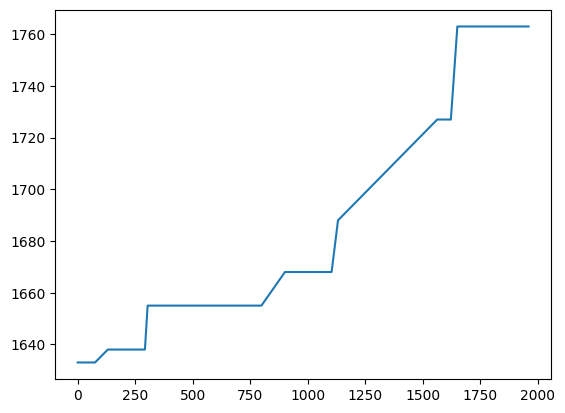

In [62]:
plt.plot(distances_min_distance, elevations_min_distance)
plt.show()

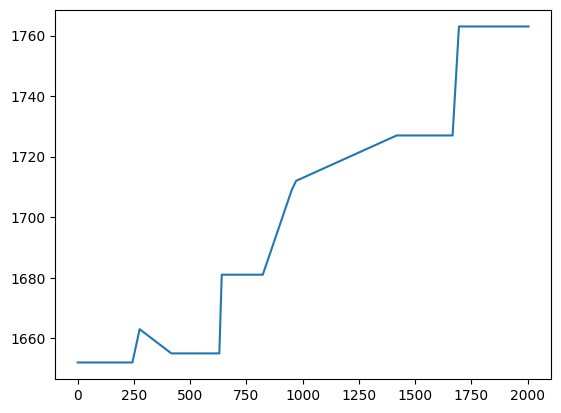

In [63]:
plt.plot(distances_min_cost, elevations_min_cost)
plt.show()

In [64]:
total_distance_min_distance = 0
for i in range(1, len(min_distance_path)):
    total_distance_min_distance += distances[(min_distance_path[i-1], min_distance_path[i])]

In [65]:
total_distance_min_cost = 0
for i in range(1, len(path)):
    total_distance_min_cost += distances[(path[i-1], path[i])]

In [66]:
total_distance_min_distance, total_distance_min_cost

(1992.3359999999998, 2037.0399999999995)

# Saving cost graph

It is neccesary because to save the dictionaries in json we have to have keys in string format

In [67]:
dict_cost_matrix_output = dict((str(k), v) for k,v in dict_cost_matrix.items())
dict_paths_output = dict((str(k), v) for k,v in dict_paths.items())

In [68]:
dict_cost_matrix_output

{'(3791874410, 3791874410)': 0,
 '(3791874410, 416767512)': 110.72355529589237,
 '(3791874410, 1838314584)': 148.4423081471694,
 '(3791874410, 6349911457)': 82.92362881946693,
 '(3791874410, 329582048)': 91.83723420057804,
 '(3791874410, 1839319073)': 72.49132114030266,
 '(416767512, 3791874410)': 201.51377577808304,
 '(416767512, 416767512)': 0,
 '(416767512, 1838314584)': 37.718752851277024,
 '(416767512, 6349911457)': 94.62021150618096,
 '(416767512, 329582048)': 103.53381688729208,
 '(416767512, 1839319073)': 102.2664854961842,
 '(1838314584, 3791874410)': 183.46864370443438,
 '(1838314584, 416767512)': 100.48588962822922,
 '(1838314584, 1838314584)': 0,
 '(1838314584, 6349911457)': 76.57507943253232,
 '(1838314584, 329582048)': 85.48868481364343,
 '(1838314584, 1839319073)': 84.22135342253556,
 '(6349911457, 3791874410)': 180.48369229869922,
 '(6349911457, 416767512)': 192.97040990276494,
 '(6349911457, 1838314584)': 230.68916275404194,
 '(6349911457, 6349911457)': 0,
 '(634991145

In [69]:
with open("lugares_poligono.json", "w") as outfile:
    json.dump(lugares_poligono, outfile)

with open("lugares_dentro_grafo.json", "w") as outfile:
    json.dump(lugares_dentro_grafo, outfile)

with open("dict_cost_matrix.json", "w") as outfile:
    json.dump(dict_cost_matrix_output, outfile)
    
with open("dict_paths.json", "w") as outfile:
    json.dump(dict_paths_output, outfile)